In [1]:
!git clone --depth 1 https://github.com/chulminkw/automl

Cloning into 'automl'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 147 (delta 14), reused 19 (delta 0), pack-reused 0
Receiving objects: 100% (147/147), 9.62 MiB | 27.28 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
!cd /content/automl/efficientdet; pip install -r requirements.txt

In [3]:
import os
import sys
import tensorflow.compat.v1 as tf

sys.path.append('/content/automl/efficientdet')

import hparams_config
from _keras import anchors
from model_inspect import ModelInspector

In [4]:
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!tar -xvf VOCtrainval_06-Nov-2007.tar > /dev/null 2>&1

--2021-10-04 10:53:20--  http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar [following]
--2021-10-04 10:53:20--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  61.3MB/s    in 7.4s    

2021-10-04 10:53:28 (59.6 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



In [5]:
!ls -lia /content/VOCdevkit/VOC2007/Annotations/*.xml| wc -l

5011


In [ ]:
!mkdir -p /content/tfrecord/train
!mkdir -p /content/tfrecord/val

!cd /content/automl/efficientdet; PYTHONPATH='/content/automl/efficientdet:$PYTHONPATH' python dataset/create_pascal_tfrecord.py \
    --data_dir=/content/VOCdevkit --year=VOC2007 --set=train --output_path=/content/tfrecord/train/pascal

!cd /content/automl/efficientdet; PYTHONPATH='/content/automl/efficientdet:$PYTHONPATH' python dataset/create_pascal_tfrecord.py \
    --data_dir=/content/VOCdevkit --year=VOC2007 --set=val --output_path=/content/tfrecord/val/pascal

In [7]:
# soft link로 Google Drive Directory 연결. 
!ln -s /content/drive/My\ Drive/ /mydrive
!ls /mydrive
!mkdir -p /mydrive/model_trained

'2020년 공부.zip'   model_trained			  tf_idf.ipynb
 CCTV		    MOS.zip				  ultra_workdir
'Colab Notebooks'  'My Drive'				  공모전.zip
'Computer Vision'   object-detection-and-tracking.ipynb   공부파일.zip


In [8]:
config = hparams_config.get_detection_config('efficientdet-d0')
print(config)

act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b0
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
delta: 0.1
drop_remainder: true
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 3
fpn_config: null
fpn_name: null
fpn_num_filters: 64
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: 512
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: true
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_instances_per_image: 100
max_level: 7
mean_rgb:
- 123.675
- 116.28
- 103.53

In [9]:
class TRAIN_CFG:
    model_name = 'efficientdet-d0'
    strategy = ''
    model_dir = '/mydrive/model_trained'
    pretrained_ckpt = '/content/efficientdet-d0'
    hparams = 'num_classes=20, moving_average_decay=0, mixed_precision=true'
    use_xla = False
    use_fake_data = False
    batch_size = 8
    eval_samples = 5000
    steps_per_execution = 1
    num_examples_per_epoch = 2500
    num_epochs = 15
    train_file_pattern = '/content/tfrecord/train/pascal-*.tfrecord'
    val_file_pattern = '/content/tfrecord/val/pascal-*.tfrecord'
    val_json_file = None
    mode = 'traineval'

    num_cores = 2
    tpu = None
    gcp_project = None
    eval_master = ''
    eval_name = None
    tf_random_seed = 2021
    profile = False
    debug = False

In [10]:
from _keras.train import setup_model
import hparams_config

import utils
from _keras import tfmot
from _keras import train_lib
from _keras import util_keras

config = hparams_config.get_detection_config(TRAIN_CFG.model_name)
config.override(TRAIN_CFG.hparams)

steps_per_epoch = TRAIN_CFG.num_examples_per_epoch // TRAIN_CFG.batch_size

if tf.config.list_physical_devices('GPU'):
    ds_strategy = tf.distribute.OneDeviceStrategy('device:GPU:0')
else:
    ds_strategy = tf.distribute.OneDeviceStrategy('device:CPU:0')

print(ds_strategy)

params = dict(
    profile = TRAIN_CFG.profile,
    mode = TRAIN_CFG.mode,
    model_name = TRAIN_CFG.model_name,
    steps_per_execution = TRAIN_CFG.steps_per_execution,
    num_epochs = TRAIN_CFG.num_epochs,
    model_dir = TRAIN_CFG.model_dir,
    steps_per_epoch = steps_per_epoch,
    strategy = TRAIN_CFG.strategy,
    batch_size = TRAIN_CFG.batch_size,
    tf_randodm_seed = TRAIN_CFG.tf_random_seed,
    debug = TRAIN_CFG.debug,
    val_json_file = TRAIN_CFG.val_json_file,
    eval_samples = TRAIN_CFG.eval_samples,
    num_shards=ds_strategy.num_replicas_in_sync
)

config.override(params, True)

config.image_size = utils.parse_image_size(config.image_size)
print(config)

act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b0
batch_size: 8
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
debug: false
delta: 0.1
drop_remainder: true
eval_samples: 5000
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 3
fpn_config: null
fpn_name: null
fpn_num_filters: 64
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: !!python/tuple
- 512
- 512
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: true
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_instan

In [11]:
import utils
from _keras import tfmot
from _keras import train_lib
from _keras import util_keras

MODEL = 'efficientdet-d0' 

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
print('Use model in {}'.format(ckpt_path))

--2021-10-04 10:54:35--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 64.233.191.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28994253 (28M) [application/octet-stream]
Saving to: ‘efficientdet-d0.tar.gz’

efficientdet-d0.tar 100%[===================>]  27.65M   150MB/s    in 0.2s    

2021-10-04 10:54:35 (150 MB/s) - ‘efficientdet-d0.tar.gz’ saved [28994253/28994253]

Use model in /content/efficientdet-d0


In [12]:
from _keras import train
model = train_lib.EfficientDetNetTrain(config=config)
model = train.setup_model(model, config)

if TRAIN_CFG.pretrained_ckpt:
    ckpt_path = tf.train.latest_checkpoint(TRAIN_CFG.pretrained_ckpt)
    util_keras.restore_ckpt(
        model,
        ckpt_path,
        config.moving_average_decay,
        exclude_layers=['class_net']
    )
train.init_experimental(config)
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


Model: ""
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      multiple                  3634844   
_________________________________________________________________
resample_p6 (ResampleFeature multiple                  20800     
_________________________________________________________________
resample_p7 (ResampleFeature multiple                  0         
_________________________________________________________________
fpn_cells (FPNCells)         multiple                  179321    
_________________________________________________________________
class_net (ClassNet)         multiple                  30324     
_________________________________________________________________
box_net (BoxNet)             multiple                  20964     
Total params: 3,886,253
Trainable params: 3,839,117
Non-trainable params: 47,136
___________________________________________________

In [13]:
import dataloader

def get_dataset(is_training, config):
  # is_training이 True이면 TRAIN_CFG의 train_file_pattern, 그렇지 아니면 val_file_pattern
  file_pattern = (
    TRAIN_CFG.train_file_pattern
    if is_training else TRAIN_CFG.val_file_pattern)
  if not file_pattern:
    raise ValueError('No matching files.')

  return dataloader.InputReader(
    file_pattern,
    is_training=is_training,
    use_fake_data=TRAIN_CFG.use_fake_data,
    max_instances_per_image=config.max_instances_per_image,
    debug=TRAIN_CFG.debug)(
        config.as_dict())

In [14]:
import pandas as pd

#  train.txt와 val.txt를 읽어서 train과 val 용 image 건수를 구함 
train_df = pd.read_csv('/content/VOCdevkit/VOC2007/ImageSets/Main/train.txt', sep=' ', 
                       header=None, names=['file_id'], dtype={'file_id':str})
val_df = pd.read_csv('/content/VOCdevkit/VOC2007/ImageSets/Main/val.txt', sep=' ', 
                       header=None, names=['file_id'], dtype={'file_id':str})

train_images_num = train_df.shape[0]
val_images_num = val_df.shape[0]
print(train_images_num, val_images_num)

train_df.head()

2501 2510


,file_id
0,000012
1,000017
2,000023
3,000026
4,000032


In [15]:
import tensorflow as tf
from _keras import train_lib
from _keras import train

# config에 기반하여 모델을 생성하고 pretrained weight를 로딩하는 함수 생성. 
def get_efficientdet_model(config):
  model = train_lib.EfficientDetNetTrain(config=config)
  model = train.setup_model(model, config)

  if TRAIN_CFG.pretrained_ckpt:
    ckpt_path = tf.train.latest_checkpoint(TRAIN_CFG.pretrained_ckpt)
    util_keras.restore_ckpt(
        model,
        ckpt_path,
        config.moving_average_decay,
        exclude_layers=['class_net'])
    
  train.init_experimental(config)
  return model

model = get_efficientdet_model(config)
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


Model: ""
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      multiple                  3634844   
_________________________________________________________________
resample_p6 (ResampleFeature multiple                  20800     
_________________________________________________________________
resample_p7 (ResampleFeature multiple                  0         
_________________________________________________________________
fpn_cells (FPNCells)         multiple                  179321    
_________________________________________________________________
class_net (ClassNet)         multiple                  30324     
_________________________________________________________________
box_net (BoxNet)             multiple                  20964     
Total params: 3,886,253
Trainable params: 3,839,117
Non-trainable params: 47,136
___________________________________________________

In [16]:
from _keras import train
import numpy as np

tr_steps_per_epoch = train_images_num // config.batch_size
val_steps_per_epoch = val_images_num // config.batch_size

val_dataset = get_dataset(False, config) if 'eval' in config.mode else None

model.fit(
    get_dataset(True, config),
    epochs = 15,
    steps_per_epoch = tr_steps_per_epoch,
    callbacks= train_lib.get_callbacks(config.as_dict(), val_dataset),
    validation_data = val_dataset,
    validation_steps = val_steps_per_epoch
)

tf.keras.backend.clear_session()

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


312/312 [==============================] - 468s 1s/step - det_loss: 85.7669 - cls_loss: 85.4658 - box_loss: 0.0060 - reg_l2_loss: 0.0954 - loss: 85.8624 - learning_rate: 0.0090 - gradient_norm: 3.2241 - val_det_loss: 1.1922 - val_cls_loss: 0.8337 - val_box_loss: 0.0072 - val_reg_l2_loss: 0.0955 - val_loss: 1.2878

Epoch 00001: saving model to /mydrive/model_trained/ckpt-1
Epoch 2/15
312/312 [==============================] - 402s 1s/step - det_loss: 0.8991 - cls_loss: 0.6810 - box_loss: 0.0044 - reg_l2_loss: 0.0956 - loss: 0.9948 - learning_rate: 0.0097 - gradient_norm: 2.5432 - val_det_loss: 0.8368 - val_cls_loss: 0.5454 - val_box_loss: 0.0058 - val_reg_l2_loss: 0.0957 - val_loss: 0.9325

Epoch 00002: saving model to /mydrive/model_trained/ckpt-2
Epoch 3/15
312/312 [==============================] - 399s 1s/step - det_loss: 0.7865 - cls_loss: 0.5841 - box_loss: 0.0040 - reg_l2_loss: 0.0958 - loss: 0.8823 - learning_rate: 0.0092 - gradient_norm: 2.6548 - val_det_loss: 0.7396 - val_cls_

In [17]:
import hparams_config

infer_config = hparams_config.get_efficientdet_config('efficientdet-d0')
print(infer_config)

act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b0
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
delta: 0.1
drop_remainder: true
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 3
fpn_config: null
fpn_name: null
fpn_num_filters: 64
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: 512
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: true
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_instances_per_image: 100
max_level: 7
mean_rgb:
- 123.675
- 116.28
- 103.53

In [18]:
infer_config = hparams_config.get_efficientdet_config('efficientdet-d0')
# config의 특정 항목을 update
infer_config.model_name = 'efficientdet-d0'
infer_config.model_dir = '/mydrive/model_trained'
# infer_config의 num_classes는 20로 바뀌어야 함. 
infer_config.num_classes =20
infer_config.is_training_bn = False
infer_config.nms_configs.score_thresh = 0.4
infer_config.nms_configs.max_output_size = 100

In [19]:
import inference
from _keras import efficientdet_keras

model = efficientdet_keras.EfficientDetModel(config=infer_config)
model.build((None, None, None, 3))
print('#### checkpoint name:', tf.train.latest_checkpoint(infer_config.model_dir))
model.load_weights(tf.train.latest_checkpoint(infer_config.model_dir))
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


#### checkpoint name: /mydrive/model_trained/ckpt-15
Model: ""
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      multiple                  3634844   
_________________________________________________________________
resample_p6 (ResampleFeature multiple                  20800     
_________________________________________________________________
resample_p7 (ResampleFeature multiple                  0         
_________________________________________________________________
fpn_cells (FPNCells)         multiple                  179321    
_________________________________________________________________
class_net (ClassNet)         multiple                  30324     
_________________________________________________________________
box_net (BoxNet)             multiple                  20964     
Total params: 3,886,253
Trainable params: 3,839,117
Non-trainable params: 47,13

In [20]:
import time

class ExportModel(tf.Module):

  def __init__(self, model):
    super().__init__()
    self.model = model

  @tf.function
  def f(self, imgs):
    #model(imgs, training=False, post_mode='global')
    return self.model(imgs, training=False, post_mode='global')

export_model = ExportModel(model)

In [21]:
!mkdir -p /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

--2021-10-04 12:53:23--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.03s   

2021-10-04 12:53:24 (10.7 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]

--2021-10-04 12:53:24--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7627

In [22]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)
imgs= img[np.newaxis, ...]

start_time = time.time()
boxes, scores, classes, valid_len = export_model.f(imgs)

print('elapsed time:', time.time() - start_time)

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


elapsed time: 6.321693658828735


In [23]:
labels_to_names =  {1:'aeroplane', 2:'bicycle', 3:'bird', 4:'boat', 5:'bottle', 6:'bus', 7:'car',
               8:'cat', 9:'chair', 10:'cow', 11:'diningtable', 12:'dog', 13:'horse',
               14:'motorbike', 15:'person', 16:'pottedplant', 17:'sheep', 18:'sofa', 19:'train',
               20:'tvmonitor'}

In [24]:
def get_detected_img(export_model, img_array, is_print=True):   
  # automl efficent은 반환 bbox 좌표값이 원본 이미지 좌표값으로 되어 있으므로 별도의 scaling작업 필요 없음. 
  '''
  height = img_array.shape[0]
  width = img_array.shape[1]
  '''
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet 모델을 다운로드 한 뒤 inference 수행. 
  start_time = time.time()
  # automl efficientdet 모델은 boxes, score, classes, num_detections를 각각 Tensor로 반환. 
  boxes, scores, classes, valid_len = export_model.f(img_tensor)
  # Tensor값을 시각화를 위해 numpy 로 변환. 
  boxes = boxes.numpy()
  scores = scores.numpy()
  classes = classes.numpy()
  valid_len = valid_len.numpy()
  
  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(valid_len[0]):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
    score = scores[0, i]
    
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = boxes[0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. 또한 원본 좌표값으로 되어 있음. '''
    left = box[1]
    top = box[0] 
    right = box[3] 
    bottom = box[2] 

    # class id 추출하고 class 명으로 매핑
    class_id = classes[0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

person: 0.8962
person: 0.8766
person: 0.8029
car: 0.8027
person: 0.7774
car: 0.7355
Detection 수행시간: 0.07 초


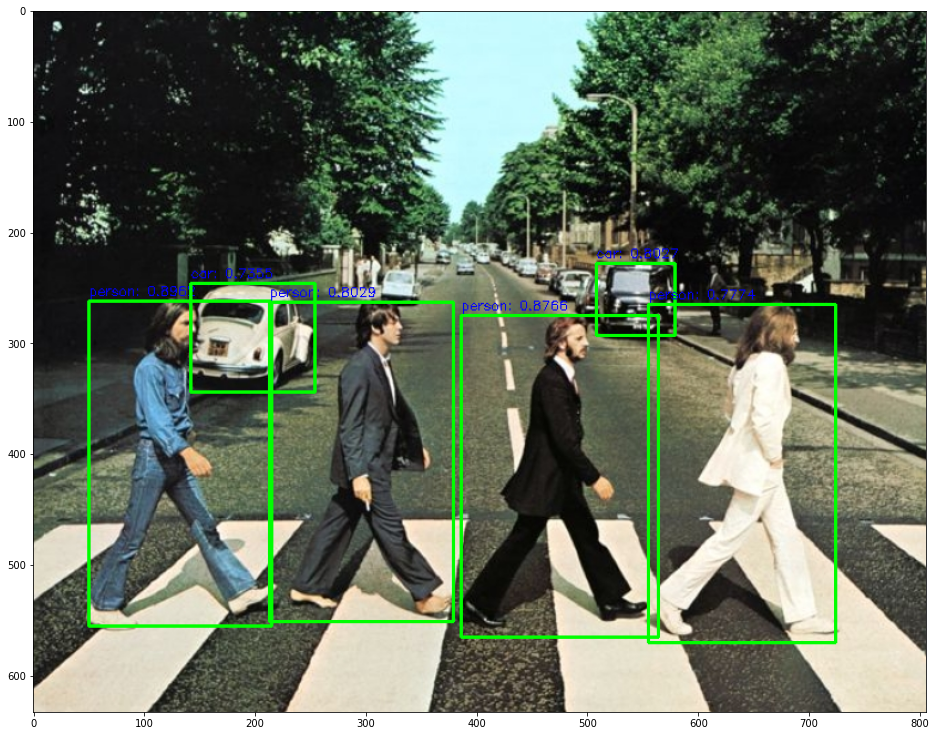

In [25]:
import cv2
img_array = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)

draw_img = get_detected_img(export_model, img_array, is_print=True)
plt.figure(figsize=(16, 16))
plt.imshow(draw_img)